In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup
freyberg_setup.setup_pest_gr()
working_dir = freyberg_setup.WORKING_DIR_GR
pst_name = freyberg_setup.PST_NAME_GR

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_gr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_grid_ies/freyberg_gr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLO

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
run():./pestchek freyberg_gr.pst
run():./pestpp freyberg_gr.init.pst


In [3]:
m = flopy.modflow.Modflow.load(freyberg_setup.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
obs = pst.observation_data
obs.loc[obs.obgnme=="calhead","weight"] = 0.5
par = pst.parameter_data
hk_par = par.loc[par.pargp=="hk"].copy()
hk_par.loc[:,"i"] = hk_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
hk_par.loc[:,"j"] = hk_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
hk_par.loc[:,"x"] = m.sr.xcentergrid[hk_par.i,hk_par.j]
hk_par.loc[:,"y"] = m.sr.ycentergrid[hk_par.i,hk_par.j]
hk_par.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,j,x,y
parnme,,,,,,,,,,,,,,
hk_i00_j00,hk_i00_j00,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,0,125.0,9875.0
hk_i00_j01,hk_i00_j01,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,1,375.0,9875.0
hk_i00_j02,hk_i00_j02,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,2,625.0,9875.0
hk_i00_j03,hk_i00_j03,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,3,875.0,9875.0
hk_i00_j04,hk_i00_j04,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,4,1125.0,9875.0


In [4]:
os.chdir(working_dir)

In [5]:
pst.filename = pst_name
ies = pyemu.EnsembleSmoother(pst=pst,num_slaves=10,slave_dir=".")

``EnsembleSmoother.initialize()`` does lots of things for you:
- make draws from parcov for the initial ``ParameterEnsemble``
- make draws from obscov for the "target" ``ObservationEnsemble``
- runs the initial ``ParameterEnsemble`` forward to get the initial ``ObservationEnsemble``

In [6]:
ies.initialize(num_reals=100)

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


### Let's visualize the first few ``hk`` fields - drawn from prior (uncalibrated)

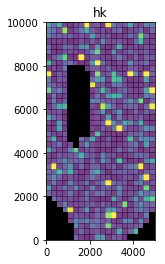

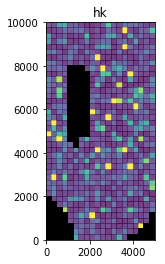

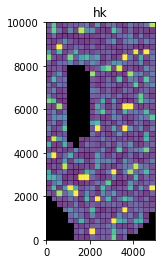

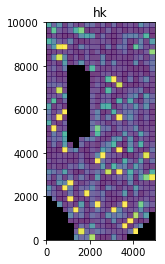

In [7]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5)
    plt.show()

### Let's visualize the distributions (histograms) for each of the forecasts

These distributions come from running the initial (uncalibrated) parameter ensemble

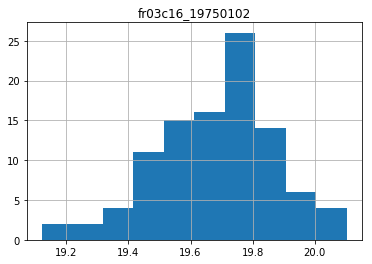

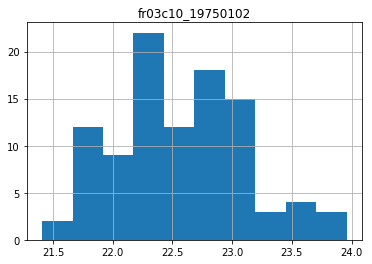

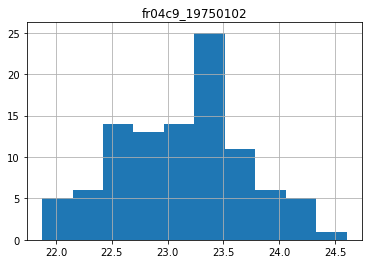

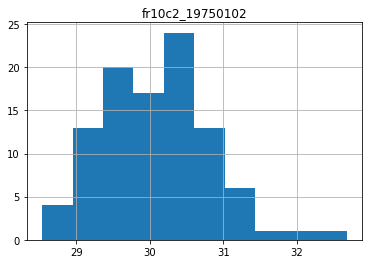

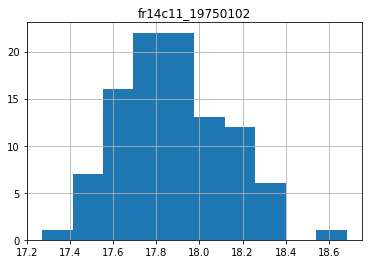

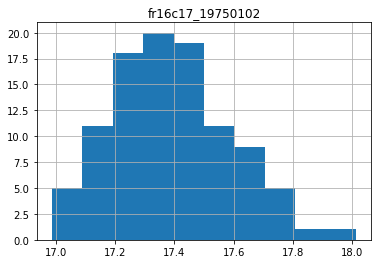

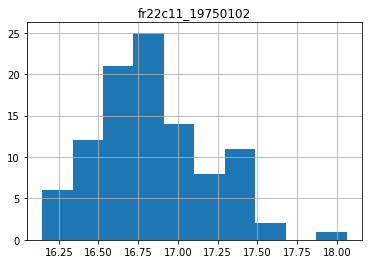

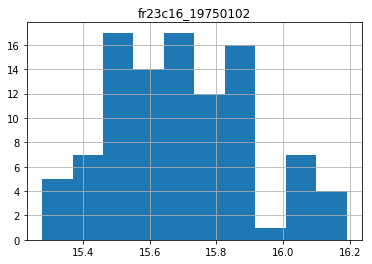

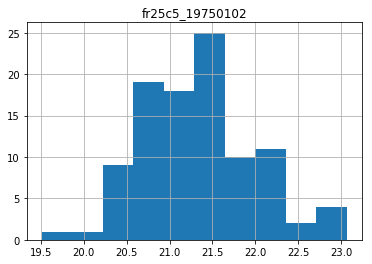

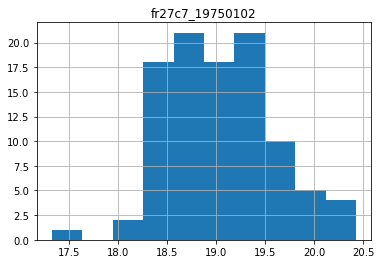

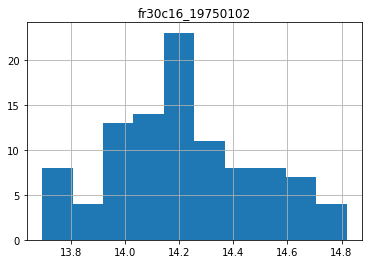

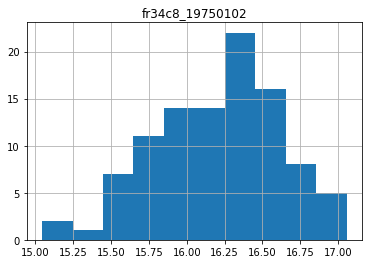

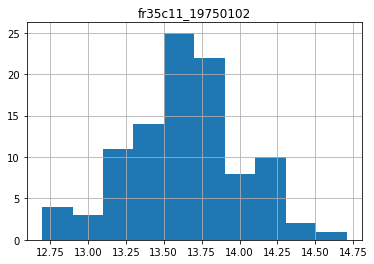

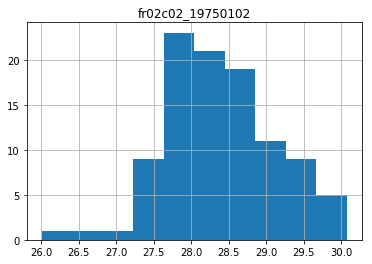

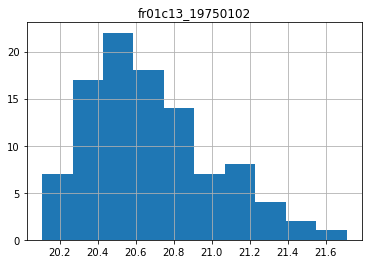

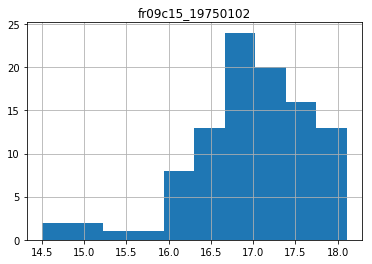

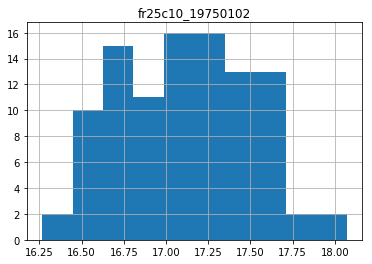

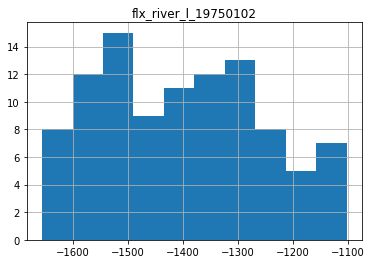

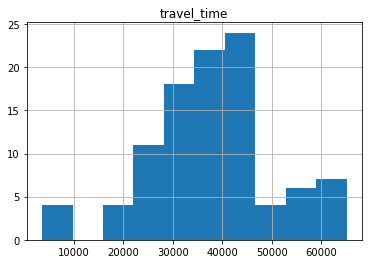

In [8]:
init_obs = ies.obsensemble.copy()
for forecast in pst.forecast_names:
    ax = ies.obsensemble.loc[:,forecast].hist(bins=10)
    ax.set_title(forecast)
    plt.show()

The initial (uncalibrated) phi distribution...not so good...

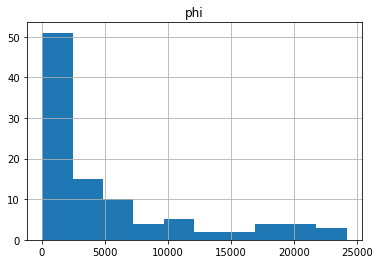

In [9]:
ies.current_phi.hist(bins=10)
plt.show()

Since we only have a few observations we are trying to match, we can look at there distributions also.  The "blue" histogram is the results of the initial parameter ensemble evaluation.  The "red" is the "target" distribution: each observation has a unique value for each realization: the observed value + a realization of measurement noise

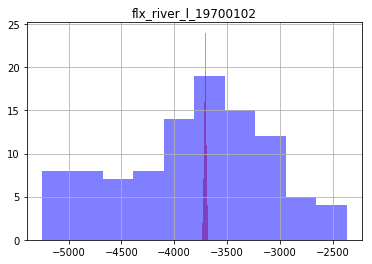

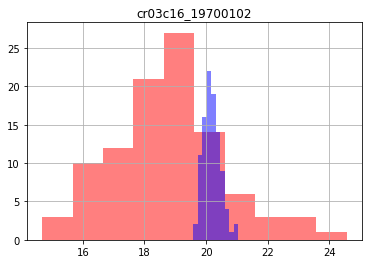

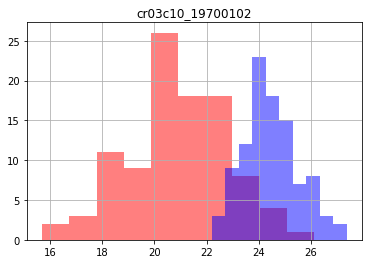

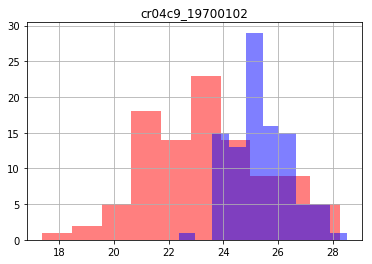

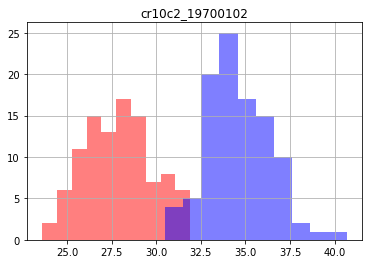

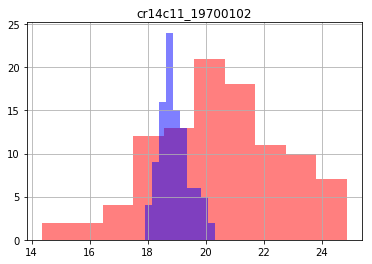

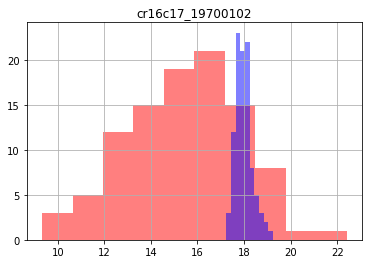

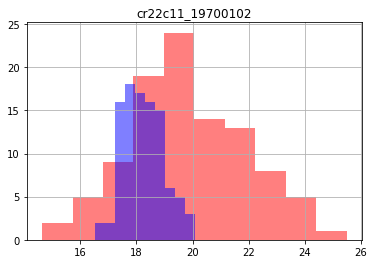

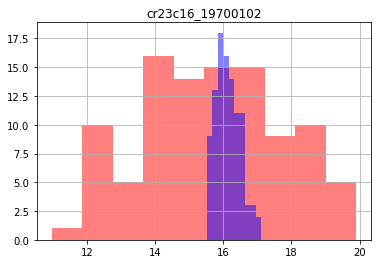

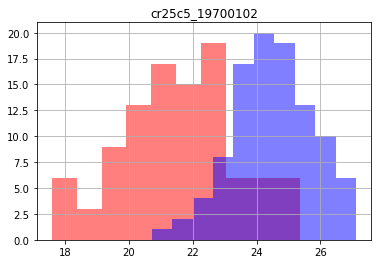

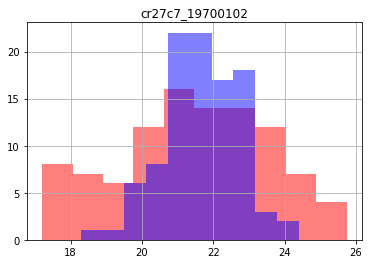

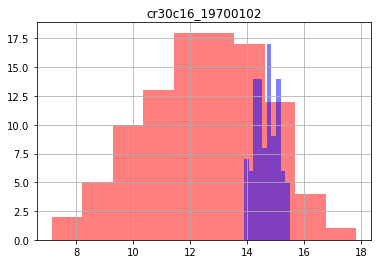

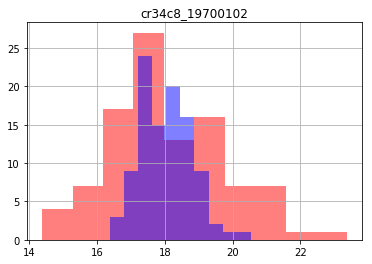

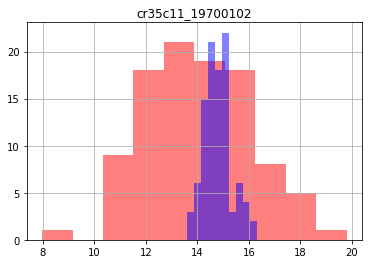

In [10]:
for oname in pst.nnz_obs_names:
    ax = ies.obsensemble_0.loc[:,oname].hist(bins=10,alpha=0.5,color='r')
    ies.obsensemble.loc[:,oname].hist(bins=10,ax=ax,alpha=0.5,color='b')
    ax.set_title(oname)
    plt.show()

``EnsembleSmoother.update()`` propagates the ensemble forward, updating the ``ParameterEnsemble`` through the GLM algorithm, then runs the new ``ParameterEnsemble``

In [11]:
ies.update()

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


Let's see how phi is doing...

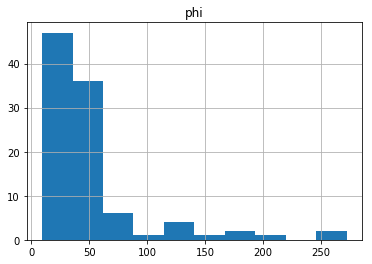

In [12]:
ies.current_phi.hist(bins=10)
plt.show()

Notice how much the ``phi`` distribution has decreased compared to the initialized ``EnsembleSmoother``: Nice!

Now let's run through a few more updates...and plot the phi distribution each time

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


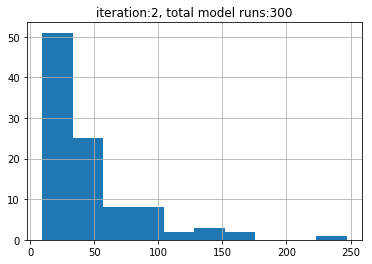

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


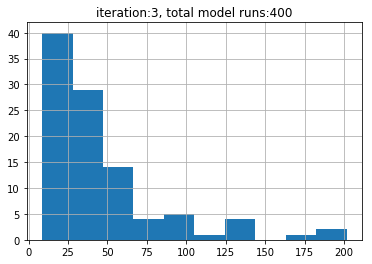

In [13]:
for i in range(2):
    ies.update()
    phi = ies.current_phi
    ax = plt.subplot(111)
    phi.hist(bins=10,ax=ax)
    ax.set_title("iteration:{0}, total model runs:{1}".format(ies.iter_num,ies.total_runs))
    plt.show()

Wow!  phi has gotten really good after only a 400ish runs of the model - remember, there over 700 parameters. Let's see how the forecasts are doing...

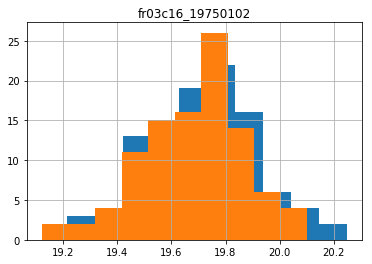

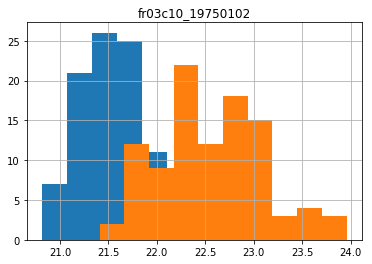

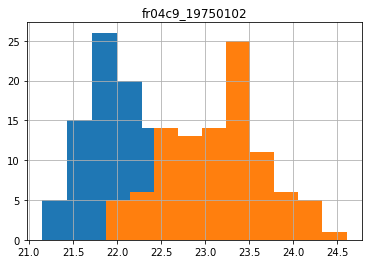

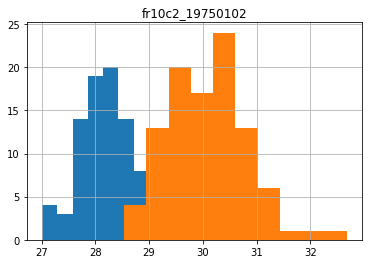

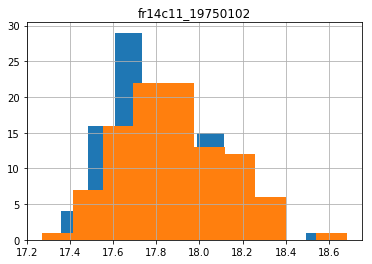

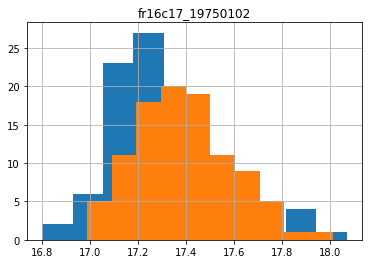

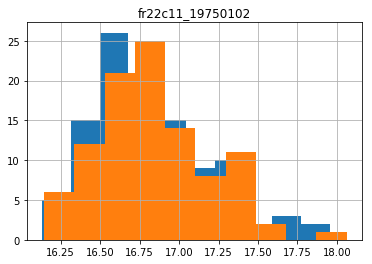

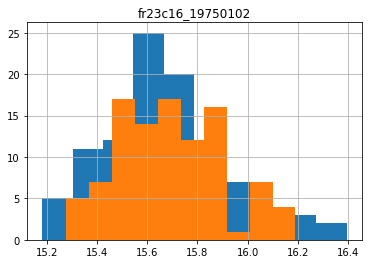

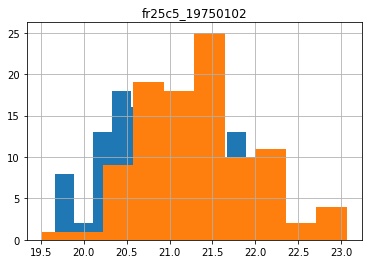

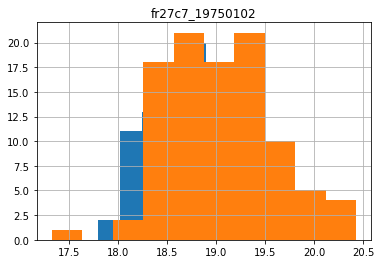

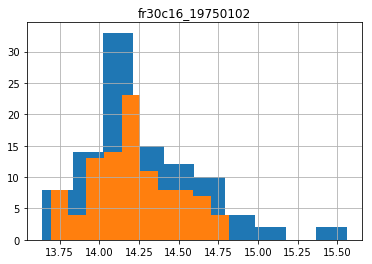

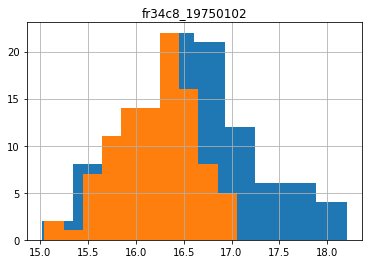

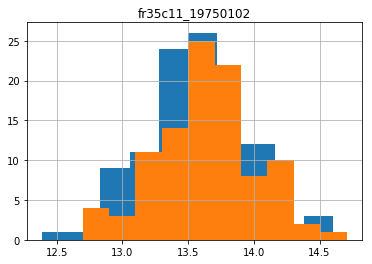

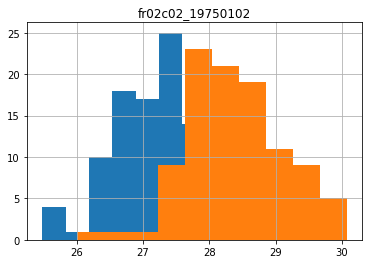

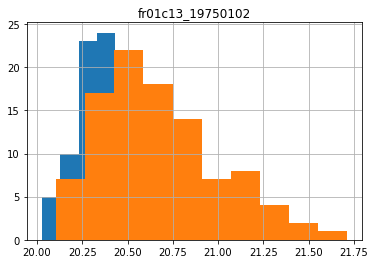

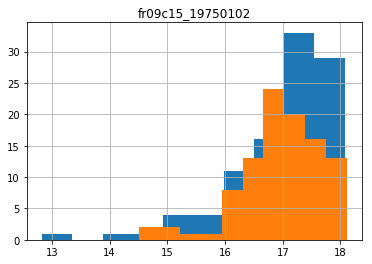

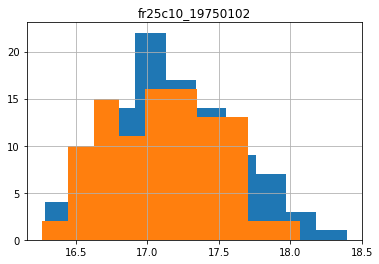

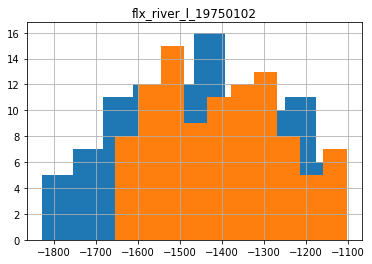

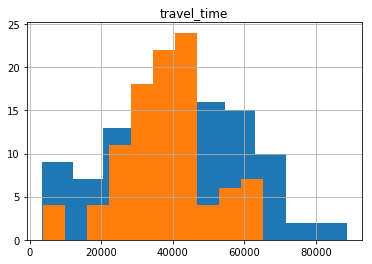

In [15]:
for forecast in pst.forecast_names:
    ax = ies.obsensemble.loc[:,forecast].hist(bins=10)
    init_obs.loc[:,forecast].hist(bins=10,ax=ax)
    ax.set_title(forecast)
    plt.show()

In [16]:
ies.total_runs

400

In [17]:
df_sum = pd.read_csv(pst_name+".iobj.csv")
df_sum

,iter_num,total_runs,lambda,min,max,mean,median,std,0000000001,0000000002,...,0000000091,0000000092,0000000093,0000000094,0000000095,0000000096,0000000097,0000000098,0000000099,0000000100
0,0,100,0.00000,19.843569,24160.845873,5176.309141,2096.1458098871776 8515.8665,4403.582600,62.892636,6724.596400,...,4870.068800,455.372770,1132.113200,129.875330,235.225710,21133.476000,18030.859000,17268.692000,NaN,NaN
1,1,200,0.10000,9.251608,272.069515,51.561627,36.786243689703255 36.642342,24.625308,33.732611,196.269490,...,133.313640,84.846935,30.025897,29.706398,272.069520,141.673320,47.339230,34.502188,NaN,NaN
2,2,300,0.07500,9.142153,246.894908,46.729894,31.56146658617105 30.931807,25.595958,38.866073,48.319806,...,65.075639,85.229531,29.827863,27.065198,132.836280,83.917615,34.259637,48.259378,NaN,NaN
3,3,400,0.05625,8.625717,201.484197,45.567044,30.267491594563896 31.118047,170.653660,75.079126,186.671070,...,39.307387,25.066705,26.788327,35.257168,29.547135,38.782395,61.249287,127.076610,NaN,NaN


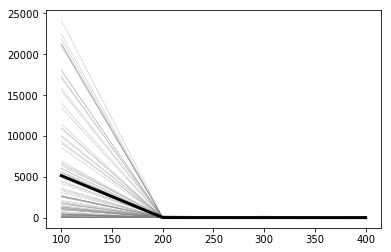

In [18]:
ax = plt.subplot(111)
real_cols = [c for c in df_sum.columns if c.startswith("0")]
[ax.plot(df_sum.total_runs,df_sum.loc[:,rc],'0.5',lw=0.25) for rc in real_cols]
ax.plot(df_sum.total_runs,df_sum.loc[:,"mean"],"k",lw=3)
plt.show()

Awesome!  We are crushing phi...but how to the parameter fields looks?

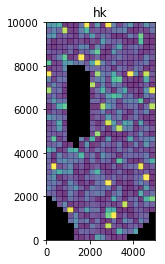

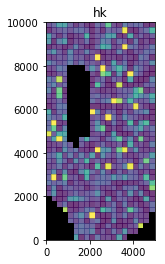

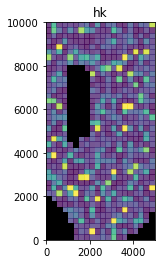

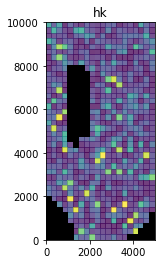

In [19]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5)
    plt.show()

Uh oh. The fields look like noise...how can we fix this? Solution: a full covariance matrix that expresses spatial correlation

### iES with a full covariance matrix

Now let's rerun the iES process but with a full, geostatistical prior covariance matrix

In [20]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v)

In [21]:
cov = pyemu.helpers.geostatistical_prior_builder(pst=pst,struct_dict={gs:[hk_par]})

Let's see how this covariance looks compare to the one we used previously

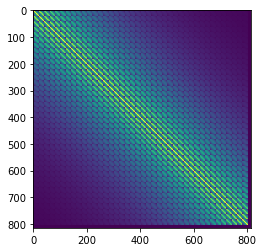

In [22]:
plt.imshow(cov.x)

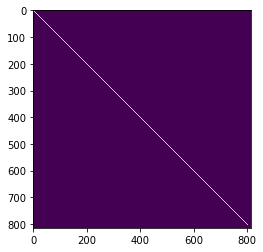

In [25]:
plt.imshow(ies.parcov.as_2d)

Now we create a new ``iES`` and update 3 times...

In [26]:
ies = pyemu.EnsembleSmoother(pst=pst,num_slaves=10,slave_dir=".",parcov=cov)
ies.initialize(num_reals=100)

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


Let's visual the new parameter fields:

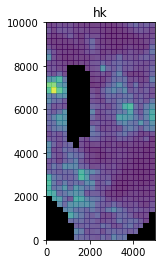

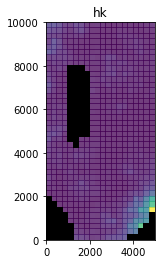

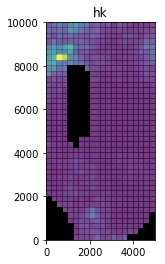

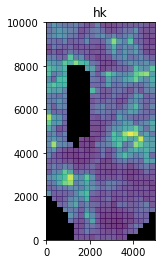

In [27]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5)
    plt.show()

Those fields look much more "geologic" (what ever that means)...let's see how well the smoother does with these fields

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


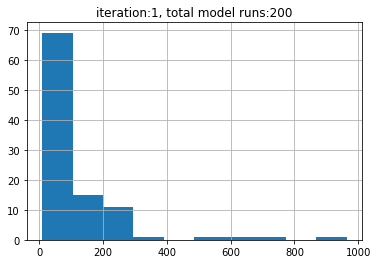

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


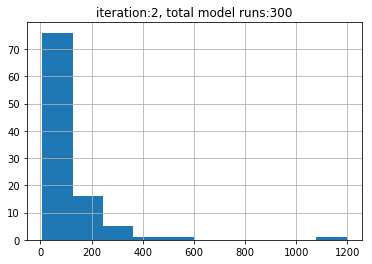

run():./sweep freyberg_gr.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4004 in ../slave_9


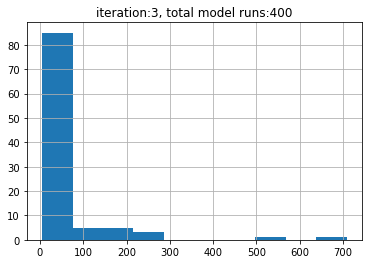

In [28]:
for _ in range(3):
    ies.update()
    phi = ies.current_phi
    ax = plt.subplot(111)
    phi.hist(bins=10,ax=ax)
    ax.set_title("iteration:{0}, total model runs:{1}".format(ies.iter_num,ies.total_runs))
    plt.show()

phi looks really good still...let's see how the final (calibrated) parameter fields look....

In [ ]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5)
    plt.show()